# Bagging 

Notebook to train a bagging model.

Evaluation metrics:
  
+ MSE
+ RMSE
+ MAE
+ MAPE

Steps:

1. 5-fold on training set
2. Find the best hyper parameters
3. 5-fold as the final training set, re-train with the best hyper parameters
4. Save model
5. Measure the performance on the test set

In [15]:
import numpy as np
import pandas as pd

In [24]:
raw_test_df = pd.read_csv('../../statistical-learning/processed_test.csv')
raw_train_df = pd.read_csv('../../statistical-learning/processed_training.csv')

## Preprocessing

In [25]:
# still need to one hot team1_name and team2_name

raw_train_df = pd.get_dummies(raw_train_df, columns=['team1_name', 'team2_name', 'season_type'])
raw_test_df = pd.get_dummies(raw_test_df, columns=['team1_name', 'team2_name', 'season_type'])

# drop columns: venue, start_hour
raw_train_df = raw_train_df.drop(columns=['venue', 'start_hour'], axis=1)
raw_test_df = raw_test_df.drop(columns=['venue', 'start_hour'], axis=1)

In [29]:
# see if there are any columns that are not in both dataframes
train_cols = set(raw_train_df.columns)
test_cols = set(raw_test_df.columns)

# make sure that the columns are the same
print(test_cols == train_cols)

True


In [32]:
raw_train_df.head(3)

,attendance,is_federal_holiday,on_grass,temperature,wind_speed,team1_pre_win,team1_pre_loss,team1_pre_win_pct,team1_streak,team2_pre_win,...,team2_name_SDP,team2_name_SEA,team2_name_SFG,team2_name_STL,team2_name_TBR,team2_name_TEX,team2_name_TOR,team2_name_WSN,season_type_post,season_type_regular
0,35055,0,1,-2.786672,-0.093090,-1.62645,-1.654514,0.0,0.007618,-1.624298,...,0,0,0,0,0,0,0,0,0,1
1,49043,0,1,0.705205,-0.093090,-1.62645,-1.654514,0.0,0.007618,-1.624298,...,0,0,0,0,0,0,0,0,0,1
2,43633,0,1,-0.521670,1.490839,-1.62645,-1.654514,0.0,0.007618,-1.624298,...,0,0,0,0,0,0,0,0,0,1


In [33]:
X, y = raw_train_df.drop(columns=['attendance'], axis=1), raw_train_df['attendance']

## Model Building

### Model Evaluation Function

In [40]:
# MSE, RMSE, MAE, MAPE

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def measure_model(y_true, y_pred, verbose=True, title=''):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    if verbose:
        print(f'''{"="*10} {title} {"="*10}
MSE: {mse:.2f}
RMSE: {rmse:.2f}
MAE: {mae:.2f}
MAPE: {mape:.2f}''')

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

In [41]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, cross_validate

### Simple Bagging Model

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bagging Regressor
regr = BaggingRegressor(n_estimators=10, random_state=42).fit(X_train, y_train)
y_pred_simple = regr.predict(X_test)

_ = measure_model(y_test, y_pred_simple, title='Simple Bagging Regressor')

========== Simple Bagging Regressor ==========
MSE: 21495061.24
RMSE: 4636.28
MAE: 3426.03
MAPE: 0.13


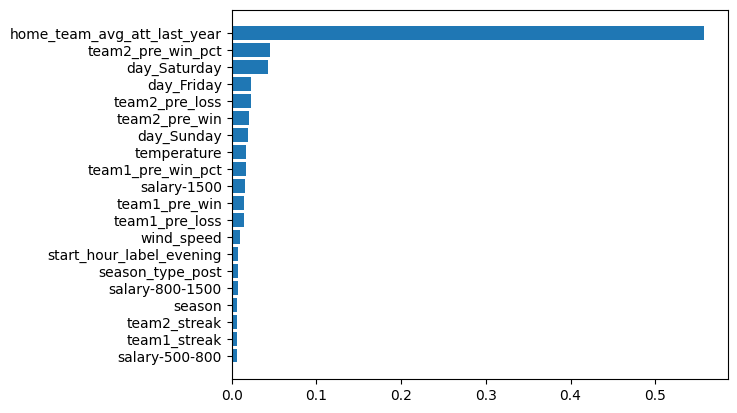

In [37]:
# matplotlib
import matplotlib.pyplot as plt

feature_importances = np.mean([
    tree.feature_importances_ for tree in regr.estimators_
], axis=0)

num_features = 20

indices = np.argsort(feature_importances)[::-1][:num_features]

fig, ax = plt.subplots()
ax.barh(range(num_features), feature_importances[indices][::-1])
ax.set_yticks(range(num_features))
_ = ax.set_yticklabels(np.array(X.columns)[indices][::-1])
# font size
plt.rcParams.update({'font.size': 8})

### Hyperparameter Tuning

In [43]:
# skf = StratifiedKFold(n_splits=5)
scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']
n_estimators_grid = np.geomspace(5, 500, 10, endpoint=True, dtype=int) # 10 numbers between 5 and 1000
n_estimators_dict = {}

for n_estimators in n_estimators_grid:
    regr = BaggingRegressor(n_estimators=n_estimators, random_state=42)
    results = cross_validate(regr, X, y, cv=5, scoring=scoring)

    metric_dict = {}
    metric_dict['MSE'] = results['test_neg_mean_squared_error'].mean()
    metric_dict['RMSE'] = results['test_neg_root_mean_squared_error'].mean()
    metric_dict['MAE'] = results['test_neg_mean_absolute_error'].mean()
    metric_dict['MAPE'] = results['test_neg_mean_absolute_percentage_error'].mean()
    metric_dict['fit_time'] = results['fit_time'].mean()
    metric_dict['score_time'] = results['score_time'].mean()

    n_estimators_dict[n_estimators] = metric_dict

### Use the best hyperparameters to train the model

In [39]:
metric_df = pd.DataFrame(n_estimators_dict).T.reset_index().rename(columns={'index': 'n_estimators'})
metric_df

,n_estimators,MSE,RMSE,MAE,MAPE,fit_time,score_time
0,5,-3.508660e+07,-5916.830610,-4444.372029,-0.185523,1.874060,0.044598
1,9,-3.269430e+07,-5708.527877,-4299.205297,-0.179355,3.317197,0.055614


In [81]:
best_grid = metric_df[abs(metric_df['RMSE']) == abs(metric_df['RMSE']).min()]
best_rmse = best_grid['RMSE'].values[0]
best_nest = best_grid['n_estimators'].values[0]

print(f'Best number of trees = {best_nest} with RMSE = {best_rmse}')

Best number of trees = 1000 with RMSE = -5653.819367550194


In [89]:
# regr = BaggingRegressor(n_estimators=1000, random_state=0).fit(scaled_X, y) # too big
regr = BaggingRegressor(n_estimators=29, random_state=0).fit(scaled_X, y) # fit time 爆炸成長前

In [90]:
# save model in YYYYMMDD format
from datetime import datetime
import pickle

regr_filename = f'{datetime.today().strftime("%Y%m%d")}_bagging_model_29.pkl'
pickle.dump(regr, open(regr_filename, 'wb'))

### Feature Importance

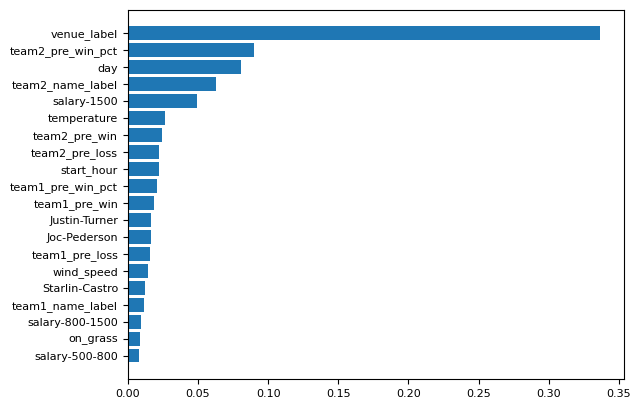

In [91]:
# matplotlib
import matplotlib.pyplot as plt

feature_importances = np.mean([
    tree.feature_importances_ for tree in regr.estimators_
], axis=0)

num_features = 20

indices = np.argsort(feature_importances)[::-1][:num_features]

fig, ax = plt.subplots()
ax.barh(range(num_features), feature_importances[indices][::-1])
ax.set_yticks(range(num_features))
_ = ax.set_yticklabels(np.array(X.columns)[indices][::-1])
# font size
plt.rcParams.update({'font.size': 8})

## Model Evaluation

In [85]:
X_test, y_test = process_data(raw_test_df)
ss = StandardScaler().fit(X_test)
scaled_X_test = ss.transform(X_test)

/var/folders/j3/sr9rbcw10dzch_cpwn25txkh0000gn/T/ipykernel_94121/1460645059.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  processed_df['weather'] = processed_df['weather'].str.replace('.', '')


In [92]:
# read model
import pickle
regr = pickle.load(open('20221125_bagging_model_29.pkl', 'rb'))
y_pred = regr.predict(scaled_X_test)

# performance
test_performance = measure_model(y_test, y_pred, title='Bagging Regressor')

========== Bagging Regressor ==========
MSE: 86679336.31
RMSE: 9310.17
MAE: 7347.44
MAPE: 0.45


Note:

+ The model doesn't perform well on the test set, which can be improved through following ways:
    1. Player data may be too noisy, we can try to cut down player features with PCA or maybe just use salary ranks
    2. Venue capacities vary a lot, it'd be better if we can first group venues by capacity and then train models for each group
+ Metrics looked good on the training set, but not on the testing set, which means the model is probably overfitting. We can try to reduce the number of features or use regularization to reduce overfitting
+ When comparing the bagging model with the baseline model, we see that baseline (MA-5) did slightly better (廢話), but it does slightly better than **average attendance of a stadium**. 

```
==================== MA(5) ====================
MSE:  32362577.913605437
RMSE:  5688.81164335799
MAE:  4399.588064076346
MAPE 0.21121206067333725
```

```
==================== Average Attendance Only ====================
MSE:  88887032.10373585
RMSE:  9427.991944403424
MAE:  7635.267692974473
MAPE 0.48553017390069386
```

```
========== Bagging Regressor ==========
MSE: 86679336.31
RMSE: 9310.17
MAE: 7347.44
MAPE: 0.45
```